<center>

# Flight Delay Predict

#### Data Science Bootcamp Capstone Project
#### Elia Abu-Manneh
##### April 11 2023

</center>


Project Description: 
A tool that allows users to get a prediction on the likelihood of their flight being delay or cancelled using historical data and forecasted data. 

#### Data Sources
* [Buereau of Transportation Statistics - Airline On-Time Performance Data](https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr) 
* [Kaggle - 2019 Airline Delays w/Weather and Airport Detail by Jen Wadkins -  Raw Data](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations)

* [NOAA National Centers for Environmental Information - Global Historical Climatology Network daily (GHCNd) ](https://noaa-ghcn-pds.s3.amazonaws.com/index.html#csv/by_year/)

#### Languages Used:
* Python
* SQL

#### Softwares Used:
* Visual Code Studio
* Google Chrome
* GitHub Desktop
* GitHub
* CUDNN


#### Packages Used:
* Pandas
* Numpy
* SQlite



Legal: 

This project was created and is intended for educational purposes only. The creator(s) nor any user(s) nor distributor(s) claim legal responsibility for any information, data, claim or prediction infered or supplied by this program whether implicitly or explicitly. The program is not to be sold or resold. The information provided by the program is not to be sold or resold. The project may be used by others for educational and non-commerical purposes. 

## Part 1: Data Exploration and Organisation


[List of imported CSVs with Column Descriptions](raw_data_documentation.txt)

In [4]:
#imports
import pandas as pd
import numpy as np
import sqlite3 
import matplotlib.pyplot as plt
import datetime
import os

In [5]:
#Exploring Historical Weather Datasets
weather_2019 = pd.read_csv('../raw_data/airport_weather_2019.csv') 
#Sample dataset with weather station column as "STATION" and airport name as "NAME"
print("weather_2019's shape is " + str(weather_2019.shape))
weather_2019.head(2) #contains only US airports

weather_2019's shape is (38675, 32)


,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/1/2019,4.70,NaN,0.14,0.0,0.0,64.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/2/2019,4.92,NaN,0.57,0.0,0.0,56.0,59.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[weather_2019 documentation can be found here](../bin/weather_2019_documentation.txt)

In [6]:
#Columns with too few input data should not be used as input features as they will not provide enough meaning to the rows or might cause data skewness

nan_percentages = (weather_2019.isna().sum() / len(weather_2019)) * 100 #Finding percentage of Nan by column in weather_2019

cols_to_drop = nan_percentages[nan_percentages > 80].index #excluding columns with more than 80% Nan
weather_2019.drop(cols_to_drop, axis=1, inplace=True)

nan_percentages = (weather_2019.isna().sum() / len(weather_2019)) * 100 #Finding percentage of Nan by column in weather_2019

print(nan_percentages)

STATION     0.000000
NAME        0.000000
DATE        0.000000
AWND        0.985133
PRCP        0.067227
SNOW       30.427925
SNWD       31.777634
TAVG       25.683258
TMAX        0.051713
TMIN        0.054299
WDF2        0.956690
WDF5        1.243697
WSF2        0.956690
WSF5        1.243697
WT01       64.186167
dtype: float64


In [7]:
#It seems WT01 also has too many NaN despite being below the limit. Let's drop it aswell
weather_2019.drop("WT01", axis=1, inplace=True)

In [8]:
nan_percentages = (weather_2019.isna().sum() / len(weather_2019)) * 100
print(nan_percentages)

STATION     0.000000
NAME        0.000000
DATE        0.000000
AWND        0.985133
PRCP        0.067227
SNOW       30.427925
SNWD       31.777634
TAVG       25.683258
TMAX        0.051713
TMIN        0.054299
WDF2        0.956690
WDF5        1.243697
WSF2        0.956690
WSF5        1.243697
dtype: float64


In [9]:
weather_2019.head(3)

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/1/2019,4.70,0.14,0.0,0.0,64.0,66.0,57.0,310.0,310.0,15.0,19.0
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/2/2019,4.92,0.57,0.0,0.0,56.0,59.0,49.0,70.0,50.0,12.1,15.0
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/3/2019,5.37,0.15,0.0,0.0,52.0,55.0,51.0,340.0,330.0,15.0,18.1


In [10]:
#List of Airport IDs
airport_ids = weather_2019['STATION'].unique().tolist()

#List of target columns
cols = ['ID', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']

### Obtaining the weather data for same airports for years 2017 - 2022

In [11]:
#Exploring Historical Weather Datasets
df2020 = pd.read_csv('../raw_data/2020.csv')

#filtering out any uncessary airports
df2020 = df2020[df2020['ID'].isin(airport_ids)]

#dropping unncessary columns
df2020 = df2020.drop(['M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME'], axis=1)

c:\Users\Elia\anaconda3\envs\python3.6\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
df2020.sample(3)

,ID,DATE,ELEMENT,DATA_VALUE
95070,USW00013881,20200307,RHAV,61
56476,USW00013880,20200209,AWND,25
11575,USW00012917,20200109,WSF2,107


In [13]:
#Pivoting DataFrame from Long-form to Wide-Form
df2020 = pd.pivot_table(df2020, values='DATA_VALUE', index=['ID', 'DATE'], columns=['ELEMENT']).reset_index()

In [14]:
#dropping any columns not in the specified list
df2020 = df2020.drop(df2020.columns.difference(cols), axis=1)

In [15]:
#Using a function to convert datasets from long to wide format

def long_to_wide(year):
    #read the CSV file for the given year
    df = pd.read_csv(f'../raw_data/{year}.csv')

    #filtering out any unnecessary airports
    df = df[df['ID'].isin(airport_ids)]

    #dropping unnecessary columns
    df = df.drop(['M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME'], axis=1)

    #pivoting DataFrame from Long-form to Wide-Form
    df = pd.pivot_table(df, values='DATA_VALUE', index=['ID', 'DATE'], columns=['ELEMENT']).reset_index()

    #dropping any columns not in the specified list
    df = df.drop(df.columns.difference(cols), axis=1)

    return df

In [16]:
df2017 = long_to_wide(2017)
df2018 = long_to_wide(2018)
df2019 = long_to_wide(2019)
df2021 = long_to_wide(2021)
df2022 = long_to_wide(2022)

In [17]:
df2022.sample(3)

ELEMENT,ID,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
3676,USW00003974,20220202,97.0,0.0,NaN,NaN,NaN,-32.0,-110.0,20.0,10.0,134.0,188.0
17916,USW00014734,20220208,49.0,13.0,0.0,0.0,31.0,78.0,-10.0,300.0,300.0,107.0,139.0
12419,USW00013886,20220116,67.0,97.0,NaN,NaN,NaN,44.0,-27.0,50.0,40.0,170.0,215.0


In [18]:
#Checking for any abnormally high percentages of Nan in the columns for all years
dfs = {}
dfs['df2017'] = df2017
dfs['df2018'] = df2018
dfs['df2019'] = df2019
dfs['df2020'] = df2020
dfs['df2021'] = df2021
dfs['df2022'] = df2022

#Looping through each dataframe and calculate the percentage of NaN values in each column
for year in range(2017, 2023):
    curdf = dfs[f"df{year}"]
    nan_percentages = round((curdf.isna().sum() / len(curdf)) * 100,2)
    nan_percentages = nan_percentages.tolist()
    print(nan_percentages)
    print(round(max(nan_percentages),1))

[0.0, 0.0, 1.03, 0.06, 28.66, 31.65, 25.79, 0.06, 0.06, 1.0, 2.03, 1.0, 2.03]
31.6
[0.0, 0.0, 1.07, 0.03, 29.03, 30.86, 25.51, 0.28, 0.28, 1.06, 1.53, 1.06, 1.53]
30.9
[0.0, 0.0, 0.99, 0.07, 29.49, 30.84, 25.68, 0.05, 0.05, 0.96, 1.24, 0.96, 1.24]
30.8
[0.0, 0.0, 0.11, 0.04, 27.38, 29.58, 21.77, 0.03, 0.04, 0.11, 0.52, 0.12, 0.52]
29.6
[0.0, 0.0, 1.06, 0.09, 32.05, 33.86, 25.59, 0.04, 0.2, 1.07, 1.79, 1.06, 1.79]
33.9
[0.0, 0.0, 1.68, 0.07, 23.75, 28.62, 25.61, 0.1, 0.59, 1.68, 1.9, 1.68, 1.89]
28.6


In [19]:
#Dropping rows containing NaNs
for df in dfs:
    dfs[df] = dfs[df].dropna()

In [20]:
#Exporting Processed Weather Data

#creating a dictionary to store the folder names
folder_names = {}
folder_names['df2017'] = 'weather2017'
folder_names['df2018'] = 'weather2018'
folder_names['df2019'] = 'weather2019'
folder_names['df2020'] = 'weather2020'
folder_names['df2021'] = 'weather2021'
folder_names['df2022'] = 'weather2022'

#exporting each dataframe to its respective folder
for key, df in dfs.items():
    file_name = f'weather{key[-4:]}.csv'
    file_path = f'../processed_data/{file_name}'
    df.to_csv(file_path, index=False)

### Importing Flight Delay Data

In [ ]:
#importing unprocessed datasets
ontime_reporting_df1 = pd.read_csv('../raw_data/01_2019_to_01_2020_T_ONTIME_REPORTING.csv')
ontime_reporting_df2 = pd.read_csv('../raw_data/08_2020_to_01_2023_T_ONTIME_REPORTING.csv')

[ontime_reporting documentation can be found here](../bin/ontime_reporting_documentation.txt)

### Organising the columns and Concatenating the datasets into one dataframe

In [22]:
#comparing columns of each dataset
cols1 = ontime_reporting_df1.columns.tolist()
print(cols1)
cols2 = ontime_reporting_df2.columns.tolist()
print(cols2)

['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 32']
['YEAR', 'MONTH', 'DAY_OF_MONTH', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEP_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']


In [23]:
#changing the DEP_DELAY_NEW column to DEP_DELAY for consistency
ontime_reporting_df1 = ontime_reporting_df1.rename(columns={'DEP_DELAY_NEW': 'DEP_DELAY'})

In [24]:
# Adding a YEAR column to the first dataframe

#Most rows have YEAR = 2019
ontime_reporting_df1['YEAR'] = 2019

#For rows in the year 2020: 

#finding the index of the last row of 2019
last_2019_index = ontime_reporting_df1[ontime_reporting_df1['MONTH'] == 12].index[-1]

#find the index of the first row of 20020
first_2020_index = ontime_reporting_df1.loc[last_2019_index+1:][ontime_reporting_df1['MONTH'] == 1].index[0]

#setting the YEAR to 2020
ontime_reporting_df1.loc[first_2020_index:, 'YEAR'] = 2020


#Moving the Year column to the first position

#removing the 'YEAR' column and save it to a variable
year_col = ontime_reporting_df1.pop('YEAR')

#inserting the 'YEAR' column at the beginning of the dataframe
ontime_reporting_df1.insert(0, 'YEAR', year_col)

c:\Users\Elia\anaconda3\envs\python3.6\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


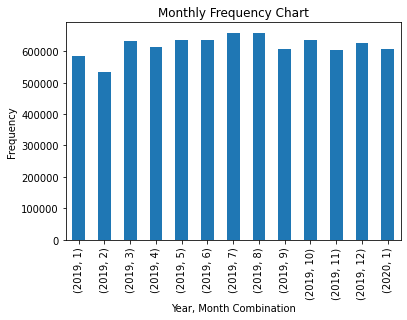

In [25]:
#Checking that the above changes were done correctly
freq_counts = ontime_reporting_df1.groupby(['YEAR', 'MONTH']).size()
freq_counts.plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel("Year, Month Combination")
plt.title("Monthly Frequency Chart")
plt.show()

In [26]:
#insuring the same columns are in each dataframe

#removing extra columns from df1
cols2 = ontime_reporting_df2.columns.tolist()
#print(cols2)
for col in ontime_reporting_df1.columns.tolist():
    #print(col)
    if col in cols2:
        pass
    else: 
        ontime_reporting_df1 = ontime_reporting_df1.drop(col, axis=1)

#removing extra columns from df2
cols1 = ontime_reporting_df1.columns.tolist()
#print(cols1)
for col in ontime_reporting_df2.columns.tolist():
    #print(col)
    if col in cols1:
        pass
    else: 
        ontime_reporting_df2 = ontime_reporting_df2.drop(col, axis=1)

In [27]:
#concatenation
ontime_df = pd.concat([ontime_reporting_df1, ontime_reporting_df2])

In [28]:
#result
print(ontime_df.shape)
ontime_df.sample(3)

(23094617, 17)


,YEAR,MONTH,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEP_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
1106464,2020,11,6,9E,4683,11953,GNV,"Gainesville, FL",10397,-5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2644636,2021,3,13,9E,5478,11146,CRW,"Charleston/Dunbar, WV",10397,-3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6961423,2019,12,10,AA,398,13930,ORD,"Chicago, IL",12953,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Slicing the dataframe based on a chosen Departure Airport

In [47]:
def slice_by_id(id):
    sliced_df = ontime_df[ontime_df['ORIGIN_AIRPORT_ID'] == id]
    filename = f"ontime_{id}.csv"
    file_path = os.path.join("..", "processed_data", filename)
    
    #dropping columns with NaN > 50%
    nan_percentages = sliced_df.isna().mean() * 100
    filtered_columns = nan_percentages[nan_percentages > 50]
    sliced_df.drop(filtered_columns.index, axis=1, inplace=True)
    cols_to_drop = ['OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME']
    sliced_df.drop(cols_to_drop, axis=1, inplace=True)

    # One-hot encode categorical features
    sliced_df = pd.get_dummies(sliced_df, columns=['OP_UNIQUE_CARRIER'])
    sliced_df = pd.get_dummies(sliced_df, columns=['DEST_AIRPORT_ID'])

    # Create intervals of 5 for DEP_DELAY column
    #sliced_df['DEP_DELAY_intervals'] = pd.cut(sliced_df['DEP_DELAY'], bins=range(-20, 301, 5), right=False)
    #sliced_df = pd.get_dummies(sliced_df, columns=['DEP_DELAY_intervals'])


    sliced_df.drop('YEAR', axis = 1, inplace=True)

    #Converting month and day into day of the year
    sliced_df['date'] = pd.to_datetime(sliced_df['MONTH'].astype(str) + ' ' + sliced_df['DAY_OF_MONTH'].astype(str), format='%m %d')

    #calculating the number of days between January 1st and each date
    sliced_df['YTD'] = sliced_df['date'] - pd.to_datetime(sliced_df['MONTH'].astype(str).apply(lambda x: '01') + ' ' + '01', format='%m %d')

    #extracting the number of days as an integer
    sliced_df['YTD'] = sliced_df['YTD'].apply(lambda x: x.days + 1)

    #droping MONTH, DAY_OF_MONTH and date columns
    sliced_df = sliced_df.drop(['MONTH', 'DAY_OF_MONTH', 'date'], axis=1)

    #moving YTD column to the first position
    cols = list(sliced_df.columns)
    cols = [cols[-1]] + cols[:-1]
    sliced_df = sliced_df[cols]


    sliced_df.to_csv(file_path, index=False)

In [ ]:
#Slicing for Austin-Bergstrom International Airport
slice_by_id(10423)